# Analytical tests of the Gaussian Stack Model

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta

## Equations

The equations used in the model are declared below. 

The pseudo-gaussian diffusion equation: 
$$
    f_{i,k}(x) = \frac{1}{2\pi\sigma^2}\exp\left\{-\frac{(x_i - \bar{x}_k)^2}{2\sigma^2}\right\}
$$

The fall trajectory equation:
$$
    \bar{x}_k = -\frac{v}{u}z_k, 
$$

Also declared is the equation for terminal velocity, directly from TEPHRA2. This is only used to get a ballpark estimate for the fall velocity.

In [2]:
def f(x, y, sigma_sqr, x_bar, y_bar):
    return 1/(2*np.pi*sigma_sqr) * np.exp(-((x - x_bar)**2 + (y - y_bar)**2)/(2*sigma_sqr))

def landing_point(x1, z1, ux, vt):
    m = vt/ux
    return x1 - (z1/m)

AIR_VISCOSITY = 0.000018325
AIR_DENSITY = 1.293
GRAVITY = 9.81

def part_fall_time(particle_ht, layer, ashdiam, part_density):
    hz = particle_ht # height of particle above sea level
    particle_fall_time = 0.0
    
    # rho is the density of air (kg/m^3) at the elevation of the current particle
    rho = AIR_DENSITY * np.exp(-hz/8200.0) 
    
    #  (friction due to the air) :
    #  vtl is terminal velocity (m/s) in laminar regime RE<6
    #  vti is terminal velocity (m/s) in intermediate regime 6<RE<500
    #  vtt is terminal velocity (m/s) in turbulent regime RE>500
    
    vtl = part_density * GRAVITY * ashdiam * ashdiam / (AIR_VISCOSITY * 18.0)
    
    reynolds_number = ashdiam * rho * vtl / AIR_VISCOSITY
    particle_term_vel = vtl
    temp0 = ashdiam * rho
    
    if reynolds_number >= 6.0:
        temp1 = 4.0 * GRAVITY * GRAVITY * part_density * part_density / (AIR_VISCOSITY * 225.0 * rho)
        vti = ashdiam * (temp1 ** (1./3.)) 
        reynolds_number = temp0 * vti / AIR_VISCOSITY
        particle_term_vel = vti

    # c...if intermediate RE>500 (turbulent regime), RE is calculated again considering vtt

    if reynolds_number >= 500.0:
        vtt = np.sqrt( 3.1 * part_density * GRAVITY * ashdiam / rho)
        reynolds_number =  temp0 * vtt / AIR_VISCOSITY
        particle_term_vel = vtt
    
    particle_fall_time = layer / particle_term_vel
    return (particle_fall_time, particle_term_vel)

print(part_fall_time(20000, 20000, 0.001, 1000))

(2130.201687720901, 9.388782346425593)


## Unit tests

Grain size: 1 mm (around 0 phi). 

$\sigma^2$: 1e9m$^2$ (from Bonadonna et al. (2005) Fig 2)

Suspended Mass ($q_{T}$): 1e10 kg

Terminal Velocity ($v$): - 9.4 m/s

Wind speed ($u$) = 20 m/s

### Test 1

Single release point at ($z_k$): 20km

Single sampling point at $x_i = \bar{x_k}$

In [3]:
s_sqr = 1e9
v = -9.4
u = 20
q = 1e10
z = 20000

In [4]:
x_bar = landing_point(0, z, u, v)
print(x_bar)

42553.1914893617


In [5]:
x = x_bar
a = f(x, 0, s_sqr, x_bar, 0)
m = q * a
print("x = %e m"%x)
print("a = %e"%a)
print("m = %f kg"%m)

x = 4.255319e+04 m
a = 1.591549e-10
m = 1.591549 kg


<IPython.core.display.Javascript object>


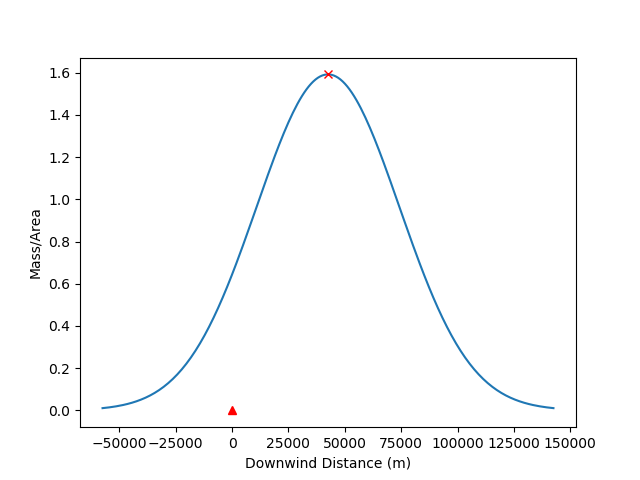

In [6]:
x_points = np.linspace(x_bar - 100000, x_bar + 100000, 200)
masses = q * f(x_points, 0, s_sqr, x_bar, 0)

plt.figure()
plt.plot(x_points, masses)

plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

In [7]:
q_inv = m/a
print("Inverted Mass: %.3e kg"%q_inv)
print("Same as Input Mass: %s"%str(q==q_inv))

Inverted Mass: 1.000e+10 kg
Same as Input Mass: True


### Test 2

Single release point at ($z_k$): 20km

Single sampling point at $x_i = \bar{x_k} + 50$km

In [8]:
x = x_bar + 50000
a = f(x, 0, s_sqr, x_bar, 0)
m = q * a
print("x = %e m"%x)
print("a = %e"%a)
print("m = %f kg"%m)

x = 9.255319e+04 m
a = 4.559865e-11
m = 0.455987 kg


<IPython.core.display.Javascript object>


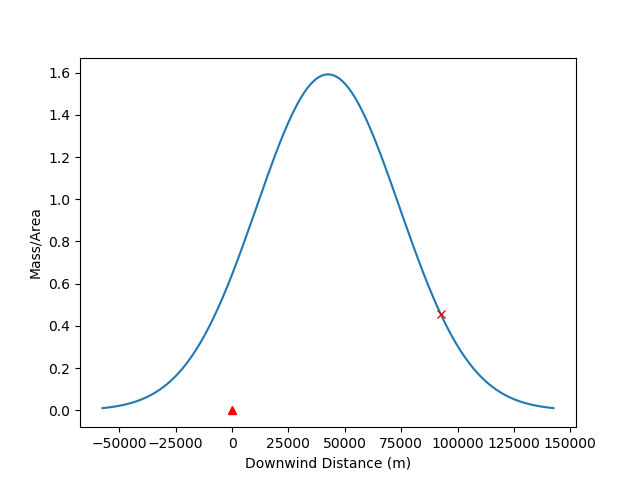

In [9]:
x_points = np.linspace(x_bar - 100000, x_bar + 100000, 200)
masses = q * f(x_points, 0, s_sqr, x_bar, 0)
plt.figure()
plt.plot(x_points, masses)

# plt.plot(x_bar, m, 'go')
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

In [10]:
q_inv = m/a
print("Inverted Mass: %.3e kg"%q_inv)
print("Same as Input Mass: %s"%str(q==q_inv))

Inverted Mass: 1.000e+10 kg
Same as Input Mass: True


### Test 3

Two release points at ($z_1, z_2$) = (15, 25) km

With ($q_1, q_2$) = (5e9, 5e9) kg

Two sampling points at $(x_1, x_2) = (\bar{x_1}, \bar{x_2})  $

In [11]:
z = [15000, 25000]
q = [5e9, 5e9]

x_bar = [landing_point(0, zk, u, v) for zk in z]
table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,15000.0,5.000000e+09,31914.893617
1,25000.0,5.000000e+09,53191.489362


In [12]:
x = x_bar
display(pd.DataFrame(x, columns=["Sampling Points"]))
n = len(x)
p = len(x_bar)
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(x[i], 0, s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,Sampling Points
0,31914.893617
1,53191.489362


,0,1
0,1.591549e-10,1.269168e-10
1,1.269168e-10,1.591549e-10


,Mass
0,1.430359
1,1.430359


<IPython.core.display.Javascript object>


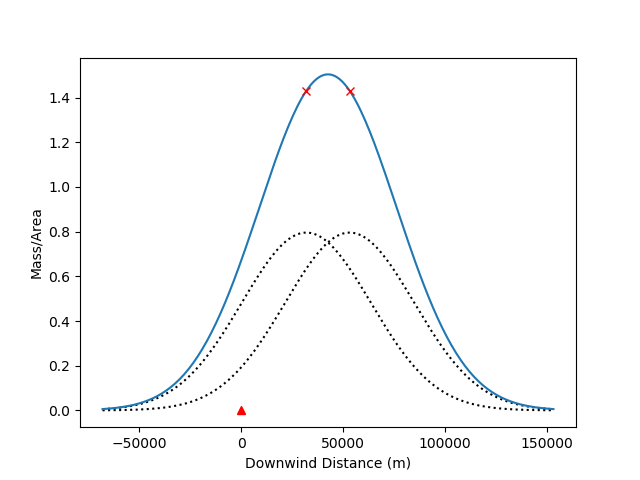

113.36588856307199


In [13]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
    
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]

print(sum(mass_tot))
plt.plot(x_points, mass_tot)
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

In [14]:
q_inv = np.linalg.solve(a, m)
res = abs(q - q_inv)
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])

,Height,Input Mass,Inverted Mass,Residual
0,15000.0,5.000000e+09,5.000000e+09,9.536743e-07
1,25000.0,5.000000e+09,5.000000e+09,1.907349e-06


### Test 3

Two release points at ($z_1, z_2$) = (15, 25) km

With ($q_1, q_2$) = (5e9, 5e9) kg

Two sampling points at $(x_1, x_2) = (\bar{x_1} + 10000, \bar{x_2} + 10000)  $

In [15]:
z = [15000, 25000]
q = [5e9, 5e9]

x_bar = [landing_point(0, zk, u, v) for zk in z]
table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,15000.0,5.000000e+09,31914.893617
1,25000.0,5.000000e+09,53191.489362


In [16]:
x = [xb + 10000 for xb in x_bar]
display(pd.DataFrame(x, columns=["Sampling Points"]))
n = len(x)
p = len(x_bar)
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(x[i], 0, s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,Sampling Points
0,41914.893617
1,63191.489362


,0,1
0,1.513929e-10,1.493507e-10
1,9.758907e-11,1.513929e-10


,Mass
0,1.503718
1,1.244910


<IPython.core.display.Javascript object>


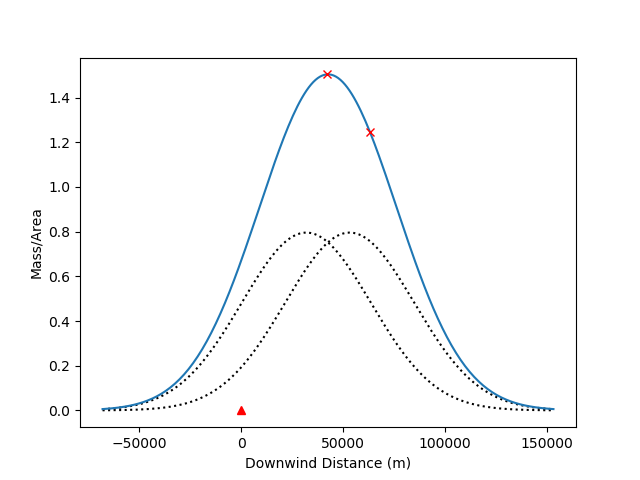

113.36588856307199


In [17]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
    
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]

print(sum(mass_tot))
plt.plot(x_points, mass_tot)
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

In [18]:
q_inv = np.linalg.solve(a, m)
res = abs(q - q_inv)
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])

,Height,Input Mass,Inverted Mass,Residual
0,15000.0,5.000000e+09,5.000000e+09,0.000002
1,25000.0,5.000000e+09,5.000000e+09,0.000002


### Test 4

Four release points at $z_k$ = $[10, 15, 20, 25]$ km

With $q_k$ = $[2.5e9, 2.5e9, 2.5e9, 2.5e9]$ kg

Four sampling points at $x_i = \bar{x_i}$

In [19]:
z = [10000, 15000,20000,25000]
q = [2.5e9, 2.5e9, 2.5e9, 2.5e9]

x_bar = [landing_point(0, zk, u, v) for zk in z]
table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,10000.0,2.500000e+09,21276.595745
1,15000.0,2.500000e+09,31914.893617
2,20000.0,2.500000e+09,42553.191489
3,25000.0,2.500000e+09,53191.489362


In [20]:
x = x_bar
display(pd.DataFrame(x, columns=["Sampling Points"]))
n = len(x)
p = len(x_bar)
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(x[i], 0, s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,Sampling Points
0,21276.595745
1,31914.893617
2,42553.191489
3,53191.489362


,0,1,2,3
0,1.591549e-10,1.503990e-10,1.269168e-10,9.564066e-11
1,1.503990e-10,1.591549e-10,1.503990e-10,1.269168e-10
2,1.269168e-10,1.503990e-10,1.591549e-10,1.503990e-10
3,9.564066e-11,1.269168e-10,1.503990e-10,1.591549e-10


,Mass
0,1.330278
1,1.467174
2,1.467174
3,1.330278


<IPython.core.display.Javascript object>


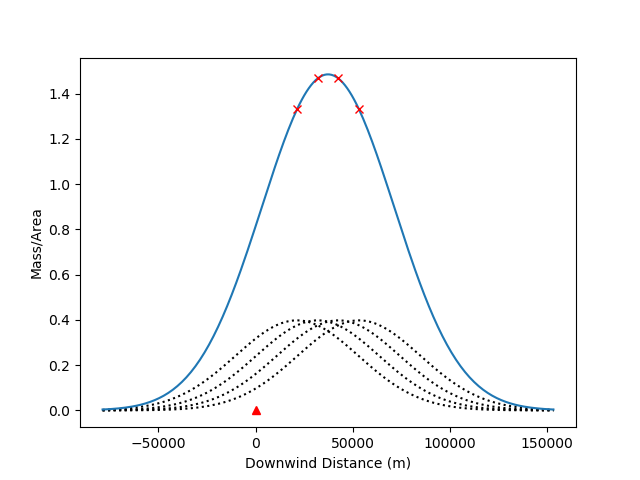

108.19620887721818


In [21]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
    
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]

print(sum(mass_tot))
plt.plot(x_points, mass_tot)
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

In [22]:
q_inv = np.linalg.solve(a, m)
res = abs(q - q_inv)
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])

,Height,Input Mass,Inverted Mass,Residual
0,10000.0,2.500000e+09,2.500000e+09,0.000059
1,15000.0,2.500000e+09,2.500000e+09,0.000131
2,20000.0,2.500000e+09,2.500000e+09,0.000104
3,25000.0,2.500000e+09,2.500000e+09,0.000029


### Test 5

Four release points at $z_k$ = $[10, 15, 20, 25]$ km

With $q_k$ = $[1.5e9, 3.5e9, 3.5e9, 1.5e9]$ kg

Four sampling points at $x_i = \bar{x_i}$

In [23]:
z = [10000, 15000,20000,25000]
q = [1.5e9, 3.5e9, 3.5e9, 1.5e9]

x_bar = [landing_point(0, zk, u, v) for zk in z]
table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,10000.0,1.500000e+09,21276.595745
1,15000.0,3.500000e+09,31914.893617
2,20000.0,3.500000e+09,42553.191489
3,25000.0,1.500000e+09,53191.489362


In [24]:
x = x_bar
display(pd.DataFrame(x, columns=["Sampling Points"]))
n = len(x)
p = len(x_bar)
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(x[i], 0, s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,Sampling Points
0,21276.595745
1,31914.893617
2,42553.191489
3,53191.489362


,0,1,2,3
0,1.591549e-10,1.503990e-10,1.269168e-10,9.564066e-11
1,1.503990e-10,1.591549e-10,1.503990e-10,1.269168e-10
2,1.269168e-10,1.503990e-10,1.591549e-10,1.503990e-10
3,9.564066e-11,1.269168e-10,1.503990e-10,1.591549e-10


,Mass
0,1.352798
1,1.499412
2,1.499412
3,1.352798


<IPython.core.display.Javascript object>


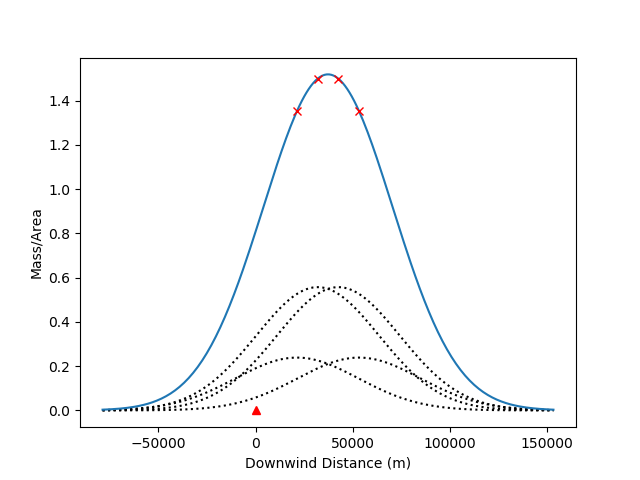

108.20642650933053


In [25]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
    
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]

print(sum(mass_tot))
plt.plot(x_points, mass_tot)
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

In [26]:
q_inv = np.linalg.solve(a, m)
res = abs(q - q_inv)
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])

,Height,Input Mass,Inverted Mass,Residual
0,10000.0,1.500000e+09,1.500000e+09,0.000237
1,15000.0,3.500000e+09,3.500000e+09,0.000601
2,20000.0,3.500000e+09,3.500000e+09,0.000564
3,25000.0,1.500000e+09,1.500000e+09,0.000195


### Test 6
#### Random sampling points

Four release points at $z_k$ = $[10, 15, 20, 25]$ km

With $q_k$ = $[1.5e9, 3.5e9, 3.5e9, 1.5e9]$ kg

Four sampling points at $x_i = \bar{x_i} + \delta$ where $\delta \sim N(\bar{x_i}, 5000)$

In [27]:
z = [10000, 15000,20000,25000]
q = [1.5e9, 3.5e9, 3.5e9, 1.5e9]

x_bar = [landing_point(0, zk, u, v) for zk in z]
table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,10000.0,1.500000e+09,21276.595745
1,15000.0,3.500000e+09,31914.893617
2,20000.0,3.500000e+09,42553.191489
3,25000.0,1.500000e+09,53191.489362


In [28]:
x = [np.random.normal(xb, 5000) for xb in x_bar]
display(pd.DataFrame(x, columns=["Sampling Points"]))
n = len(x)
p = len(x_bar)
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(x[i], 0, s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,Sampling Points
0,21941.753589
1,36825.371966
2,42523.555833
3,52395.375605


,0,1,2,3
0,1.591197e-10,1.514335e-10,1.286972e-10,9.767105e-11
1,1.410333e-10,1.572476e-10,1.565655e-10,1.392058e-10
2,1.269968e-10,1.504463e-10,1.591549e-10,1.503515e-10
3,9.807073e-11,1.290440e-10,1.516301e-10,1.591045e-10


,Mass
0,1.365644
1,1.518704
2,1.499627
3,1.368122


<IPython.core.display.Javascript object>


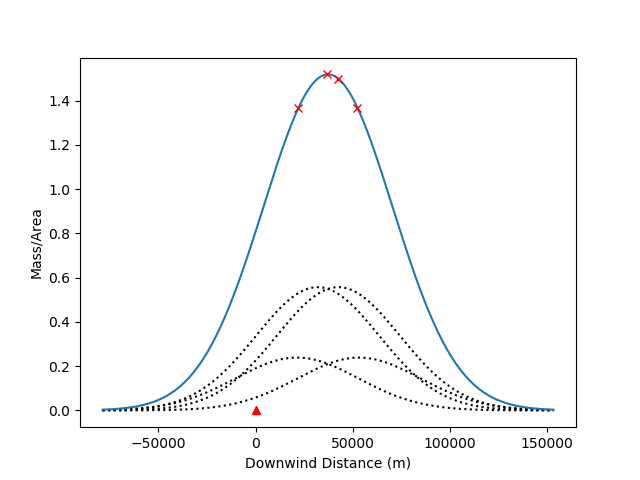

108.20642650933053


In [29]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
    
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]

print(sum(mass_tot))
plt.plot(x_points, mass_tot)
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

In [30]:
q_inv = np.linalg.solve(a, m)
res = abs(q - q_inv)
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])

,Height,Input Mass,Inverted Mass,Residual
0,10000.0,1.500000e+09,1.500000e+09,0.001048
1,15000.0,3.500000e+09,3.500000e+09,0.002867
2,20000.0,3.500000e+09,3.500000e+09,0.002899
3,25000.0,1.500000e+09,1.500000e+09,0.001084


### Test 7

Eleven release points within $z_k \in [10, 20]$ km

With $q_k$ = $1e9$ kg at each level. 

Eleven sampling points at $x_i = \bar{x_i}$

In [31]:
z = np.linspace(10000, 20000, 11)

q = [1e9]*11

x_bar = [landing_point(0, zk, u, v) for zk in z]
table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,10000.0,1.000000e+09,21276.595745
1,11000.0,1.000000e+09,23404.255319
2,12000.0,1.000000e+09,25531.914894
3,13000.0,1.000000e+09,27659.574468
4,14000.0,1.000000e+09,29787.234043
5,15000.0,1.000000e+09,31914.893617
6,16000.0,1.000000e+09,34042.553191
7,17000.0,1.000000e+09,36170.212766
8,18000.0,1.000000e+09,38297.872340
9,19000.0,1.000000e+09,40425.531915


In [32]:
x = x_bar
display(pd.DataFrame(x, columns=["Sampling Points"]))
n = len(x)
p = len(x_bar)
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(x[i], 0, s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,Sampling Points
0,21276.595745
1,23404.255319
2,25531.914894
3,27659.574468
4,29787.234043
5,31914.893617
6,34042.553191
7,36170.212766
8,38297.872340
9,40425.531915


,0,1,2,3,4,5,6,7,8,9,10
0,1.591549e-10,1.587951e-10,1.577205e-10,1.559456e-10,1.534942e-10,1.503990e-10,1.467005e-10,1.424468e-10,1.376916e-10,1.324940e-10,1.269168e-10
1,1.587951e-10,1.591549e-10,1.587951e-10,1.577205e-10,1.559456e-10,1.534942e-10,1.503990e-10,1.467005e-10,1.424468e-10,1.376916e-10,1.324940e-10
2,1.577205e-10,1.587951e-10,1.591549e-10,1.587951e-10,1.577205e-10,1.559456e-10,1.534942e-10,1.503990e-10,1.467005e-10,1.424468e-10,1.376916e-10
3,1.559456e-10,1.577205e-10,1.587951e-10,1.591549e-10,1.587951e-10,1.577205e-10,1.559456e-10,1.534942e-10,1.503990e-10,1.467005e-10,1.424468e-10
4,1.534942e-10,1.559456e-10,1.577205e-10,1.587951e-10,1.591549e-10,1.587951e-10,1.577205e-10,1.559456e-10,1.534942e-10,1.503990e-10,1.467005e-10
5,1.503990e-10,1.534942e-10,1.559456e-10,1.577205e-10,1.587951e-10,1.591549e-10,1.587951e-10,1.577205e-10,1.559456e-10,1.534942e-10,1.503990e-10
6,1.467005e-10,1.503990e-10,1.534942e-10,1.559456e-10,1.577205e-10,1.587951e-10,1.591549e-10,1.587951e-10,1.577205e-10,1.559456e-10,1.534942e-10
7,1.424468e-10,1.467005e-10,1.503990e-10,1.534942e-10,1.559456e-10,1.577205e-10,1.587951e-10,1.591549e-10,1.587951e-10,1.577205e-10,1.559456e-10
8,1.376916e-10,1.424468e-10,1.467005e-10,1.503990e-10,1.534942e-10,1.559456e-10,1.577205e-10,1.587951e-10,1.591549e-10,1.587951e-10,1.577205e-10
9,1.324940e-10,1.376916e-10,1.424468e-10,1.467005e-10,1.503990e-10,1.534942e-10,1.559456e-10,1.577205e-10,1.587951e-10,1.591549e-10,1.587951e-10


,Mass
0,1.621759
1,1.653637
2,1.678864
3,1.697118
4,1.708165
5,1.711864
6,1.708165
7,1.697118
8,1.678864
9,1.653637


<IPython.core.display.Javascript object>


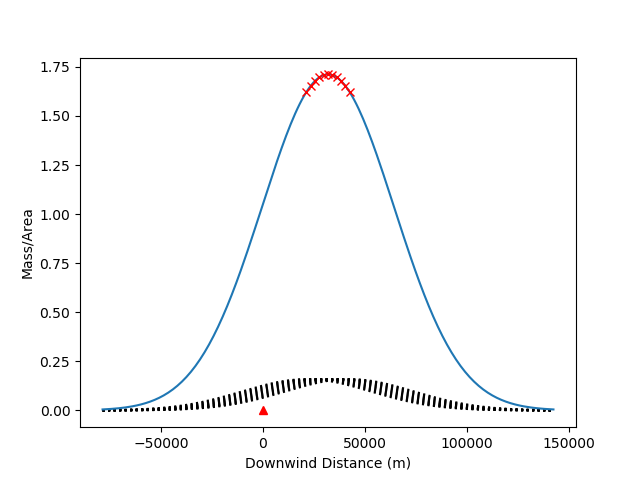

124.72966137201179


In [33]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
    
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]

print(sum(mass_tot))
plt.plot(x_points, mass_tot)
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

,Height,Input Mass,Inverted Mass,Residual
0,10000.0,1.000000e+09,1.428663e+09,-4.286627e+08
1,11000.0,1.000000e+09,-2.038198e+09,3.038198e+09
2,12000.0,1.000000e+09,1.016991e+10,-9.169912e+09
3,13000.0,1.000000e+09,-1.414122e+10,1.514122e+10
4,14000.0,1.000000e+09,1.555043e+10,-1.455043e+10
5,15000.0,1.000000e+09,-7.048246e+09,8.048246e+09
6,16000.0,1.000000e+09,3.831493e+09,-2.831493e+09
7,17000.0,1.000000e+09,-6.551746e+08,1.655175e+09
8,18000.0,1.000000e+09,2.496036e+09,-1.496036e+09
9,19000.0,1.000000e+09,2.725459e+08,7.274541e+08


<IPython.core.display.Javascript object>


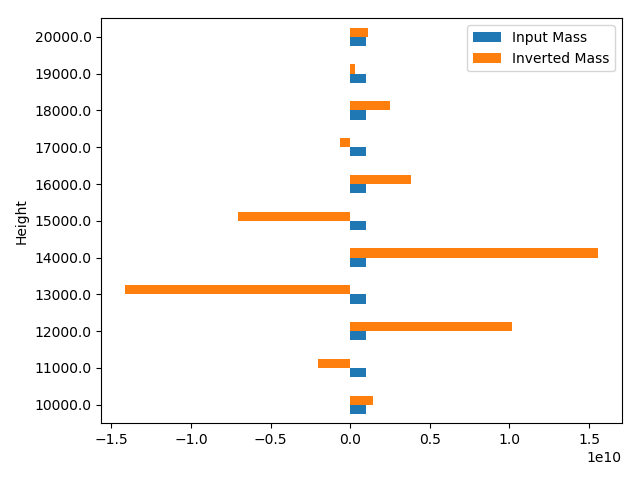

<IPython.core.display.Javascript object>


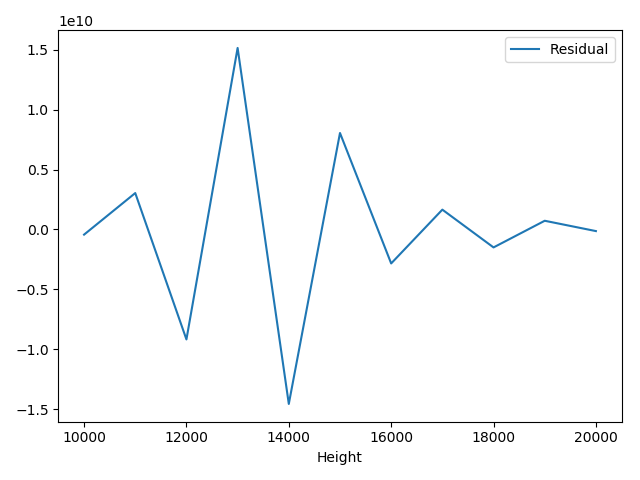

In [34]:
q_inv = np.linalg.solve(a, m)
res = q - q_inv
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
df = pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])
display(df)

ax = df.plot.barh(x="Height", y=['Input Mass', 'Inverted Mass'], rot=0)
plt.tight_layout()
df.plot(x="Height", y=['Residual'], rot=0)
plt.tight_layout()

### Test 8
#### Have a go

Set $p$ below as the number of release points in $z_k \in [z_{min}, z_{max}]$ km

With $q_k$ = $1e9$ kg at each level. 

With $p$ sampling points at $x_i = \bar{x_i}$

**It looks like too many points too close together cause instability.**

Compare $p=11$ in $z_k \in [10, 20]$ km

and $p=10$ in $z_k \in [5, 25]$ km

In [35]:
# Number of release points, p
p = 10

z_min = 5000
z_max = 25000

z = np.linspace(z_min, z_max, p)

q = [1e9]*p

x_bar = [landing_point(0, zk, u, v) for zk in z]

table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,5000.000000,1.000000e+09,10638.297872
1,7222.222222,1.000000e+09,15366.430260
2,9444.444444,1.000000e+09,20094.562648
3,11666.666667,1.000000e+09,24822.695035
4,13888.888889,1.000000e+09,29550.827423
5,16111.111111,1.000000e+09,34278.959811
6,18333.333333,1.000000e+09,39007.092199
7,20555.555556,1.000000e+09,43735.224586
8,22777.777778,1.000000e+09,48463.356974
9,25000.000000,1.000000e+09,53191.489362


In [36]:
x = x_bar
display(pd.DataFrame(x, columns=["Sampling Points"]))
n = len(x)
p = len(x_bar)
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(x[i], 0, s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,Sampling Points
0,10638.297872
1,15366.430260
2,20094.562648
3,24822.695035
4,29550.827423
5,34278.959811
6,39007.092199
7,43735.224586
8,48463.356974
9,53191.489362


,0,1,2,3,4,5,6,7,8,9
0,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10,1.064296e-10,9.203555e-11,7.782873e-11,6.435993e-11
1,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10,1.064296e-10,9.203555e-11,7.782873e-11
2,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10,1.064296e-10,9.203555e-11
3,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10,1.064296e-10
4,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10
5,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10
6,1.064296e-10,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10
7,9.203555e-11,1.064296e-10,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10
8,7.782873e-11,9.203555e-11,1.064296e-10,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10
9,6.435993e-11,7.782873e-11,9.203555e-11,1.064296e-10,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10


,Mass
0,1.206759
1,1.299785
2,1.374152
3,1.426040
4,1.452702
5,1.452702
6,1.426040
7,1.374152
8,1.299785
9,1.206759


<IPython.core.display.Javascript object>


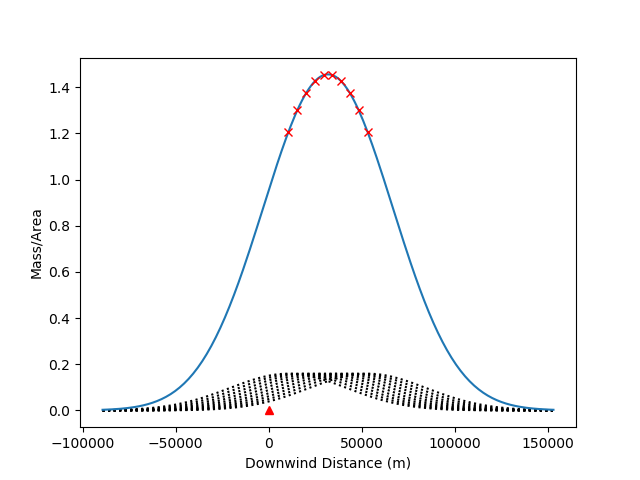

103.46815782945147


In [37]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
    
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]

print(sum(mass_tot))
plt.plot(x_points, mass_tot)
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

,Height,Input Mass,Inverted Mass,Residual
0,5000.000000,1.000000e+09,9.996234e+08,3.766369e+05
1,7222.222222,1.000000e+09,1.003104e+09,-3.104411e+06
2,9444.444444,1.000000e+09,9.883764e+08,1.162360e+07
3,11666.666667,1.000000e+09,1.025948e+09,-2.594817e+07
4,13888.888889,1.000000e+09,9.619394e+08,3.806061e+07
5,16111.111111,1.000000e+09,1.038040e+09,-3.804013e+07
6,18333.333333,1.000000e+09,9.740937e+08,2.590633e+07
7,20555.555556,1.000000e+09,1.011592e+09,-1.159240e+07
8,22777.777778,1.000000e+09,9.969072e+08,3.092767e+06
9,25000.000000,1.000000e+09,1.000375e+09,-3.748247e+05


<IPython.core.display.Javascript object>


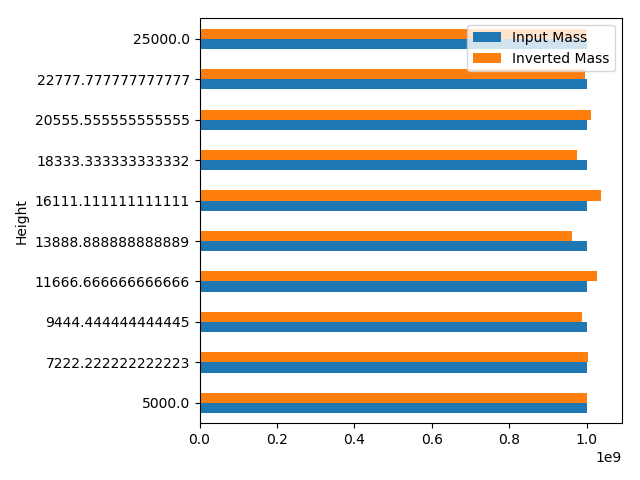

<IPython.core.display.Javascript object>


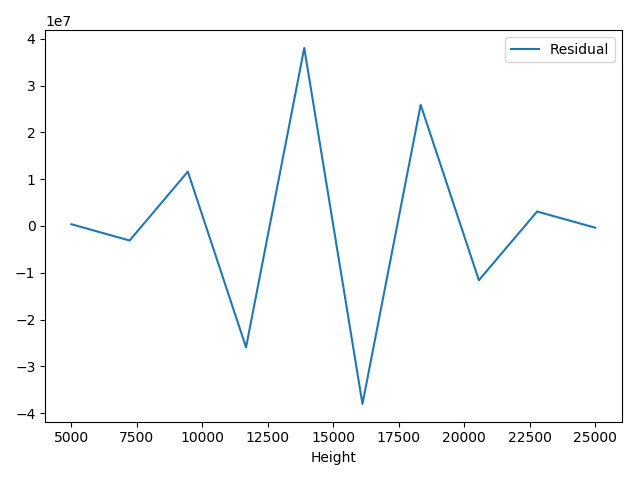

In [38]:
q_inv = np.linalg.solve(a, m)
res = q - q_inv
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
df = pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])
display(df)

ax = df.plot.barh(x="Height", y=['Input Mass', 'Inverted Mass'], rot=0)
plt.tight_layout()
df.plot(x="Height", y=['Residual'], rot=0)
plt.tight_layout()

### Test 9
#### Distribution on $q$

Here, we try a beta distribution on the suspended mass, $q$.

Set $p$ below as the number of release points in $z_k \in [z_{min}, z_{max}]$ km

With $q_k \sim \mathrm{Beta}(a, b)$, with $q_T=1e10$ kg 

With $p$ sampling points at $x_i = \bar{x_i}$

10000000000.0


,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,5000.000000,3.483871e+08,10638.297872
1,7222.222222,6.461171e+08,15366.430260
2,9444.444444,9.667861e+08,20094.562648
3,11666.666667,1.264516e+09,24822.695035
4,13888.888889,1.493429e+09,29550.827423
5,16111.111111,1.607646e+09,34278.959811
6,18333.333333,1.561290e+09,39007.092199
7,20555.555556,1.308483e+09,43735.224586
8,22777.777778,8.033453e+08,48463.356974
9,25000.000000,0.000000e+00,53191.489362


<IPython.core.display.Javascript object>


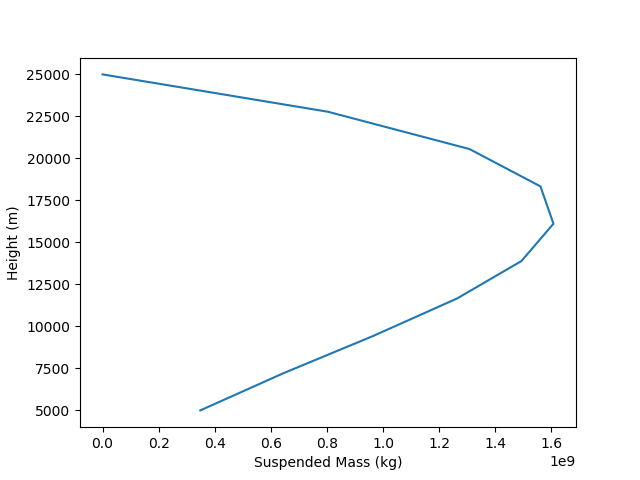

In [39]:
# Number of release points, p
p = 10

z_min = 5000
z_max = 25000

a = 3
b = 2

z = np.linspace(z_min, z_max, p)

tot_mass = 1e10

x_bar = [landing_point(0, zk, u, v) for zk in z]

q_beta = beta(a,b)

max_height = max(z)
z_norm = z/max_height
pdf = q_beta.pdf(z_norm)
pdf_sum = sum(q_beta.pdf(z_norm))
norm_beta = q_beta.pdf(z_norm)/pdf_sum
q = norm_beta * tot_mass

print(sum(q))
table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

plt.figure()
plt.plot(q, z)
plt.xlabel("Suspended Mass (kg)")
plt.ylabel("Height (m)")
plt.show()


In [40]:
x = x_bar
display(pd.DataFrame(x, columns=["Sampling Points"]))
n = len(x)
p = len(x_bar)
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(x[i], 0, s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,Sampling Points
0,10638.297872
1,15366.430260
2,20094.562648
3,24822.695035
4,29550.827423
5,34278.959811
6,39007.092199
7,43735.224586
8,48463.356974
9,53191.489362


,0,1,2,3,4,5,6,7,8,9
0,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10,1.064296e-10,9.203555e-11,7.782873e-11,6.435993e-11
1,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10,1.064296e-10,9.203555e-11,7.782873e-11
2,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10,1.064296e-10,9.203555e-11
3,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10,1.064296e-10
4,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10,1.203540e-10
5,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10,1.330914e-10
6,1.064296e-10,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10,1.439232e-10
7,9.203555e-11,1.064296e-10,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10,1.521958e-10
8,7.782873e-11,9.203555e-11,1.064296e-10,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10,1.573859e-10
9,6.435993e-11,7.782873e-11,9.203555e-11,1.064296e-10,1.203540e-10,1.330914e-10,1.439232e-10,1.521958e-10,1.573859e-10,1.591549e-10


,Mass
0,1.227638
1,1.332285
2,1.417045
3,1.477151
4,1.509085
5,1.510919
6,1.482510
7,1.425511
8,1.343220
9,1.240260


<IPython.core.display.Javascript object>


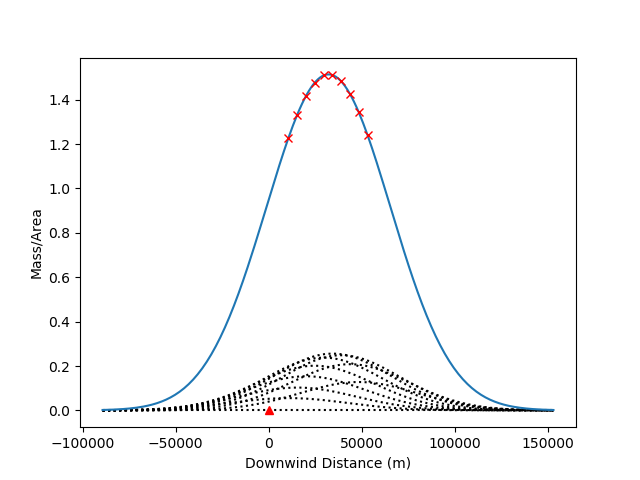

103.47969029550464


In [41]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
    
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]

print(sum(mass_tot))
plt.plot(x_points, mass_tot)
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

,Height,Input Mass,Inverted Mass,Residual
0,5000.000000,3.483871e+08,3.488127e+08,-4.255622e+05
1,7222.222222,6.461171e+08,6.426175e+08,3.499593e+06
2,9444.444444,9.667861e+08,9.798585e+08,-1.307231e+07
3,11666.666667,1.264516e+09,1.235404e+09,2.911165e+07
4,13888.888889,1.493429e+09,1.536024e+09,-4.259503e+07
5,16111.111111,1.607646e+09,1.565182e+09,4.246424e+07
6,18333.333333,1.561290e+09,1.590135e+09,-2.884432e+07
7,20555.555556,1.308483e+09,1.295610e+09,1.287289e+07
8,22777.777778,8.033453e+08,8.067704e+08,-3.425097e+06
9,25000.000000,0.000000e+00,-4.139543e+05,4.139543e+05


<IPython.core.display.Javascript object>


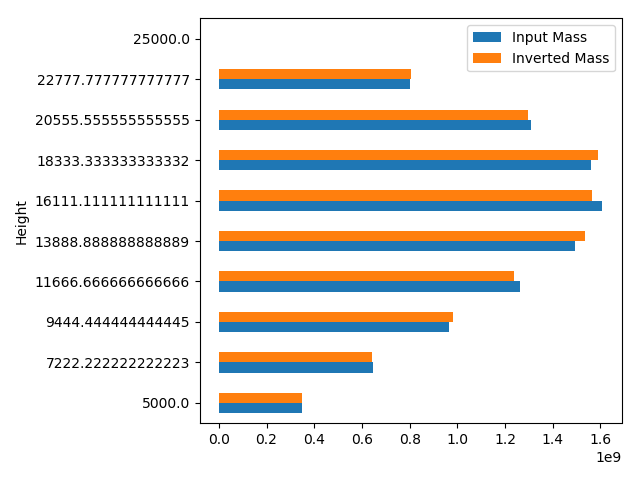

<IPython.core.display.Javascript object>


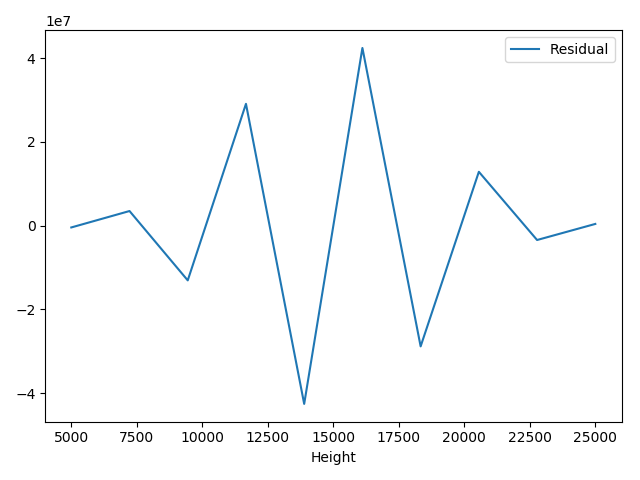

In [42]:
q_inv = np.linalg.solve(a, m)
res = q - q_inv
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
df = pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])
display(df)

ax = df.plot.barh(x="Height", y=['Input Mass', 'Inverted Mass'], rot=0)
plt.tight_layout()
df.plot(x="Height", y=['Residual'], rot=0)
plt.tight_layout()

### Test 10
#### Distribution on $q$, random sampling points

Now, we try random sampling points. 

Set $p$ below as the number of release points in $z_k \in [z_{min}, z_{max}]$ km

With $q_k \sim \mathrm{Beta}(a, b)$, with $q_T=1e10$ kg 

With $p$ sampling points at $x_i = \bar{x_i}$

**We seem to hit some instability when the matrix A is too large!**

9999999999.999998


,Release Heights (z),Suspended Masses (q),Landing Points (x_bar)
0,0.0,0.000000e+00,0.000000
1,3750.0,2.083333e+08,7978.723404
2,7500.0,7.142857e+08,15957.446809
3,11250.0,1.339286e+09,23936.170213
4,15000.0,1.904762e+09,31914.893617
5,18750.0,2.232143e+09,39893.617021
6,22500.0,2.142857e+09,47872.340426
7,26250.0,1.458333e+09,55851.063830
8,30000.0,0.000000e+00,63829.787234


<IPython.core.display.Javascript object>


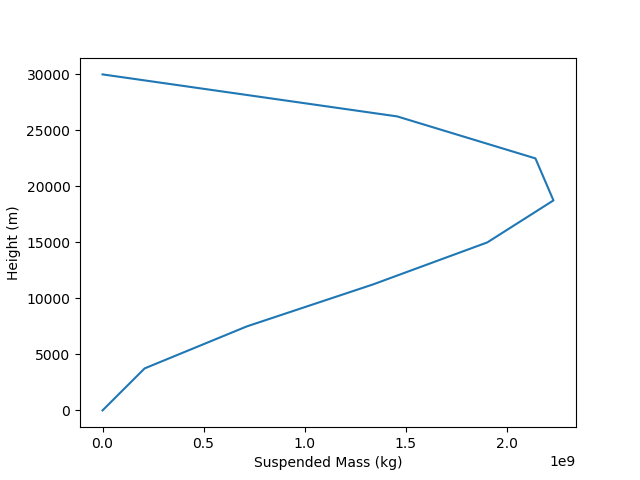

In [43]:
# Number of release points, p
p = 9

z_min = 0
z_max = 30000

a = 3
b = 2

z = np.linspace(z_min, z_max, p)

tot_mass = 1e10

x_bar = [landing_point(0, zk, u, v) for zk in z]

q_beta = beta(a,b)

max_height = max(z)
z_norm = z/max_height
pdf = q_beta.pdf(z_norm)
pdf_sum = sum(q_beta.pdf(z_norm))
norm_beta = q_beta.pdf(z_norm)/pdf_sum
q = norm_beta * tot_mass

print(sum(q))
table = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
display(pd.DataFrame(table,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"]))

plt.figure()
plt.plot(q, z)
plt.xlabel("Suspended Mass (kg)")
plt.ylabel("Height (m)")
plt.show()


In [44]:
x = [np.random.normal(xb, 5000) for xb in x_bar]
display(pd.DataFrame(x, columns=["Sampling Points"]))
n = len(x)
p = len(x_bar)
a = np.zeros((n,p))
for i in range(n):
    for k in range(p):
        a[i,k] = f(x[i], 0, s_sqr, x_bar[k], 0)
display(pd.DataFrame(a))
m = np.matmul(a, q)
display(pd.DataFrame(m, columns=["Mass"]))

,Sampling Points
0,4121.539946
1,3612.244304
2,13369.848266
3,22876.120440
4,31778.193882
5,42709.293189
6,41264.063577
7,62468.401915
8,64450.138834


,0,1,2,3,4,5,6,7,8
0,1.578089e-10,1.579754e-10,1.483885e-10,1.307868e-10,1.081634e-10,8.393624e-11,6.111834e-11,4.175864e-11,2.677158e-11
1,1.581200e-10,1.576449e-10,1.474776e-10,1.294568e-10,1.066293e-10,8.241020e-11,5.976380e-11,4.066757e-11,2.596636e-11
2,1.455474e-10,1.568588e-10,1.586230e-10,1.505138e-10,1.340106e-10,1.119579e-10,8.776539e-11,6.455718e-11,4.455728e-11
3,1.225133e-10,1.424387e-10,1.553909e-10,1.590655e-10,1.527845e-10,1.377004e-10,1.164512e-10,9.240719e-11,6.880503e-11
4,9.605793e-11,1.199015e-10,1.404330e-10,1.543356e-10,1.591535e-10,1.539993e-10,1.398216e-10,1.191194e-10,9.522342e-11
5,6.393304e-11,8.707519e-11,1.112798e-10,1.334415e-10,1.501476e-10,1.585253e-10,1.570477e-10,1.459881e-10,1.273374e-10
6,6.793265e-11,9.146179e-11,1.155457e-10,1.369684e-10,1.523491e-10,1.590056e-10,1.557175e-10,1.430920e-10,1.233804e-10
7,2.261758e-11,3.606474e-11,5.396004e-11,7.575555e-11,9.979517e-11,1.233552e-10,1.430731e-10,1.557082e-10,1.590075e-10
8,1.994479e-11,3.230971e-11,4.911221e-11,7.004847e-11,9.374770e-11,1.177268e-10,1.387212e-10,1.533781e-10,1.591243e-10


,Mass
0,0.899313
1,0.885990
2,1.134941
3,1.336387
4,1.452220
5,1.465619
6,1.472495
7,1.146607
8,1.097913


<IPython.core.display.Javascript object>


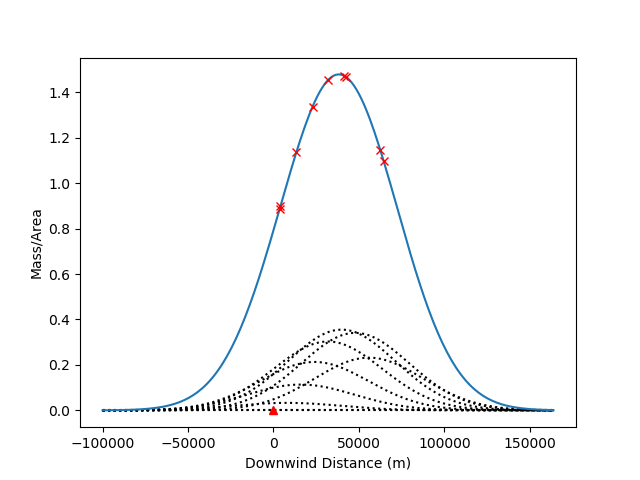

95.14685919195303


In [45]:
x_points = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 200)
plt.figure()
masses = []
for k in range(p):
    mass = q[k] * f(x_points, 0, s_sqr, x_bar[k], 0)
    masses.append(mass)
    
mass_tot = 0
for k in range(p):
    plt.plot(x_points, masses[k], "k:")
    mass_tot += masses[k]

print(sum(mass_tot))
plt.plot(x_points, mass_tot)
plt.plot(x, m, 'rx')
plt.plot(0, 0, 'r^')
plt.xlabel("Downwind Distance (m)")
plt.ylabel("Mass/Area")
plt.show()

,Height,Input Mass,Inverted Mass,Residual
0,0.0,0.000000e+00,-3.243951e+01,32.439509
1,3750.0,2.083333e+08,2.083335e+08,-211.851333
2,7500.0,7.142857e+08,7.142851e+08,642.401312
3,11250.0,1.339286e+09,1.339287e+09,-1181.259947
4,15000.0,1.904762e+09,1.904760e+09,1440.554061
5,18750.0,2.232143e+09,2.232144e+09,-1192.953758
6,22500.0,2.142857e+09,2.142856e+09,655.081035
7,26250.0,1.458333e+09,1.458334e+09,-218.070097
8,30000.0,0.000000e+00,-3.369126e+01,33.691255


<IPython.core.display.Javascript object>


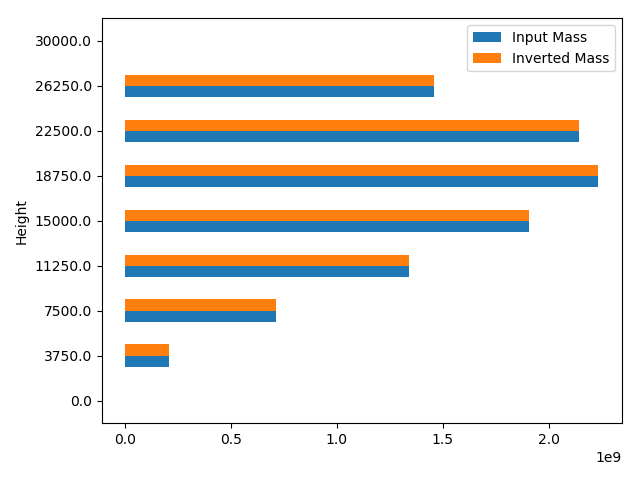

c:\users\nmostert\envs\spew\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


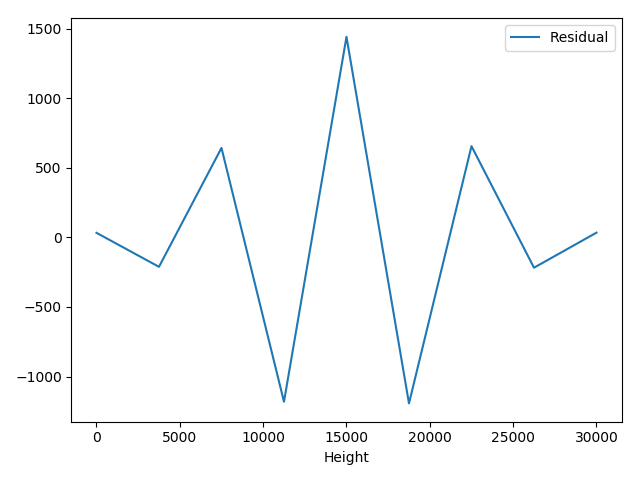

In [46]:
q_inv = np.linalg.solve(a, m)
res = q - q_inv
data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res])
df = pd.DataFrame(data.T, columns=["Height", "Input Mass", "Inverted Mass", "Residual"])
display(df)

ax = df.plot.barh(x="Height", y=['Input Mass', 'Inverted Mass'], rot=0)
plt.tight_layout()
df.plot(x="Height", y=['Residual'], rot=0)
plt.tight_layout()